In [2]:
from yahoo_fin.stock_info import get_data, get_splits
from datetime import date, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# set stock ticker symbol
stock_symbol = 'AAPL'
 
# set date range for historical prices
end_time = date.today()
start_time = end_time - timedelta(days=365)
 
# reformat date range
end = end_time.strftime('%Y-%m-%d')
start = start_time.strftime('%Y-%m-%d')
 
# get daily stock prices over date range
prices = get_data(stock_symbol, start, end, 'daily')

In [7]:
# calculate daily logarithmic return
prices['returns'] = (np.log(prices.close /
    prices.close.shift(-1)))
      
# calculate daily standard deviation of returns
daily_std = np.std(prices.returns)
  
# annualized daily standard deviation
std = daily_std * 252 ** 0.5

c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


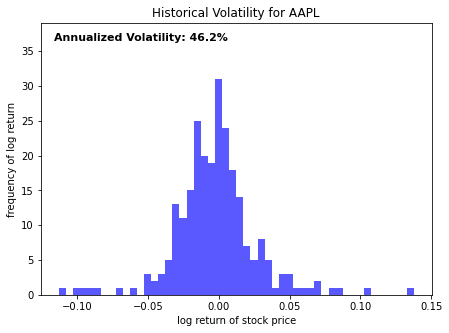

In [11]:
# Plot histograms
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
n, bins, patches = ax.hist(
    prices.returns.values,
    bins=50, alpha=0.65, color='blue')
 
ax.set_xlabel('log return of stock price')
ax.set_ylabel('frequency of log return')
ax.set_title('Historical Volatility for ' +
    stock_symbol)
  
# get x and y coordinate limits
x_corr = ax.get_xlim()
y_corr = ax.get_ylim()
  
# make room for text
header = y_corr[1] / 5
y_corr = (y_corr[0], y_corr[1] + header)
ax.set_ylim(y_corr[0], y_corr[1])
 
# print historical volatility on plot
x = x_corr[0] + (x_corr[1] - x_corr[0]) / 30
y = y_corr[1] - (y_corr[1] - y_corr[0]) / 15
ax.text(x, y , 'Annualized Volatility: ' + str(np.round(std*100, 1))+'%',
    fontsize=11, fontweight='bold')
x = x_corr[0] + (x_corr[1] - x_corr[0]) / 15
y -= (y_corr[1] - y_corr[0]) / 20

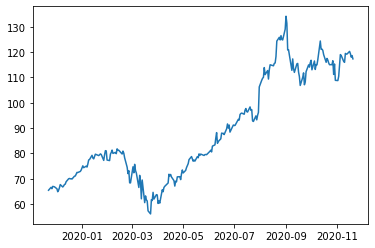

In [12]:
plt.plot(prices['close'])